# CH15 Trading Strategies 

## Simple Moving Averages

### Data Import

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt

In [5]:
plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = 'serif'
%config InlineBackend.figure_format = 'svg'

In [6]:
raw = pd.read_csv('http://hilpisch.com/tr_eikon_eod_data.csv',
                  index_col=0, parse_dates=True)

In [7]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2216 entries, 2010-01-01 to 2018-06-29
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2138 non-null   float64
 1   MSFT.O  2138 non-null   float64
 2   INTC.O  2138 non-null   float64
 3   AMZN.O  2138 non-null   float64
 4   GS.N    2138 non-null   float64
 5   SPY     2138 non-null   float64
 6   .SPX    2138 non-null   float64
 7   .VIX    2138 non-null   float64
 8   EUR=    2216 non-null   float64
 9   XAU=    2211 non-null   float64
 10  GDX     2138 non-null   float64
 11  GLD     2138 non-null   float64
dtypes: float64(12)
memory usage: 225.1 KB


In [8]:
symbol = 'AAPL.O'

In [9]:
data = (
    pd.DataFrame(raw[symbol])
    .dropna()
)

### Trading Strategy

In [10]:
SMA1 = 42  
SMA2 = 252  

In [11]:
data['SMA1'] = data[symbol].rolling(SMA1).mean()  
data['SMA2'] = data[symbol].rolling(SMA2).mean()  

<Axes: xlabel='Date'>

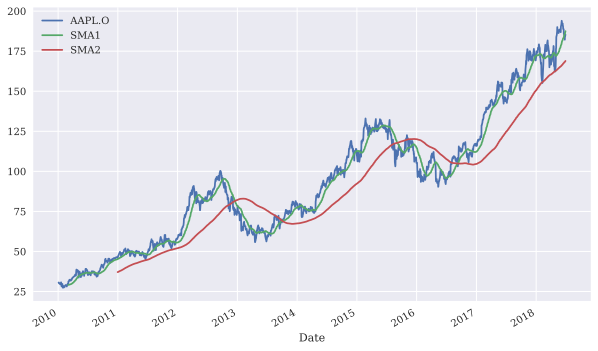

In [13]:
data.plot(figsize=(10, 6))

In [14]:
data.dropna(inplace=True)

In [15]:
data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)  

In [16]:
data.tail()

,AAPL.O,SMA1,SMA2,Position
Date,,,,
2018-06-25,182.17,185.606190,168.265556,1
2018-06-26,184.43,186.087381,168.418770,1
2018-06-27,184.16,186.607381,168.579206,1
2018-06-28,185.50,187.089286,168.736627,1
2018-06-29,185.11,187.470476,168.901032,1


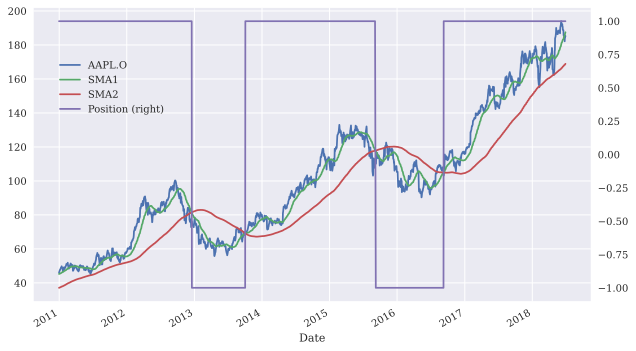

In [17]:
ax = data.plot(secondary_y='Position', figsize=(10, 6))
ax.get_legend().set_bbox_to_anchor((0.25, 0.85));
# plt.savefig('../../images/ch15/strat_plot_02.png')

### Vectorized Backtesting

In [18]:
data['Returns'] = np.log(data[symbol] / data[symbol].shift(1))  

In [19]:
data['Strategy'] = data['Position'].shift(1) * data['Returns']  

In [20]:
data.round(4).head()

,AAPL.O,SMA1,SMA2,Position,Returns,Strategy
Date,,,,,,
2010-12-31,46.0800,45.2810,37.1207,1,NaN,NaN
2011-01-03,47.0814,45.3497,37.1862,1,0.0215,0.0215
2011-01-04,47.3271,45.4126,37.2525,1,0.0052,0.0052
2011-01-05,47.7142,45.4661,37.3223,1,0.0081,0.0081
2011-01-06,47.6757,45.5226,37.3921,1,-0.0008,-0.0008


In [23]:
data.dropna(inplace=True)

In [24]:
np.exp(data[['Returns', 'Strategy']].sum())  

Returns     4.017148
Strategy    5.811299
dtype: float64

In [25]:
data[['Returns', 'Strategy']].std() * 252 ** 0.5  

Returns     0.250571
Strategy    0.250407
dtype: float64

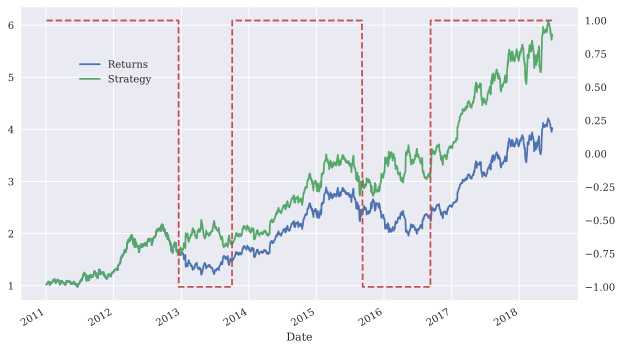

In [27]:
ax = data[['Returns', 'Strategy']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6))
data['Position'].plot(ax=ax, secondary_y='Position', style='--')
ax.get_legend().set_bbox_to_anchor((0.25, 0.85))

### Optimization

In [28]:
from itertools import product

In [29]:
sma1 = range(20, 61, 4)  
sma2 = range(180, 281, 10)  

In [33]:
results = pd.DataFrame()
for SMA1, SMA2 in product(sma1, sma2):  
    data = pd.DataFrame(raw[symbol])
    data.dropna(inplace=True)
    data['Returns'] = np.log(data[symbol] / data[symbol].shift(1))
    data['SMA1'] = data[symbol].rolling(SMA1).mean()
    data['SMA2'] = data[symbol].rolling(SMA2).mean()
    data.dropna(inplace=True)
    data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
    data['Strategy'] = data['Position'].shift(1) * data['Returns']
    data.dropna(inplace=True)
    perf = np.exp(data[['Returns', 'Strategy']].sum())
    results = pd.concat([results, pd.DataFrame(
                {'SMA1': SMA1, 'SMA2': SMA2,
                 'MARKET': perf['Returns'],
                 'STRATEGY': perf['Strategy'],
                 'OUT': perf['Strategy'] - perf['Returns']},
                 index=[0])], ignore_index=True)  

In [34]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SMA1      121 non-null    int64  
 1   SMA2      121 non-null    int64  
 2   MARKET    121 non-null    float64
 3   STRATEGY  121 non-null    float64
 4   OUT       121 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 4.9 KB


In [35]:
results.sort_values('OUT', ascending=False).head(7)

,SMA1,SMA2,MARKET,STRATEGY,OUT
56,40,190,4.650342,7.175173,2.524831
39,32,240,4.045619,6.558690,2.513071
59,40,220,4.220272,6.544266,2.323994
46,36,200,4.074753,6.389627,2.314874
55,40,180,4.574979,6.857989,2.283010
70,44,220,4.220272,6.469843,2.249571
101,56,200,4.074753,6.319524,2.244772


## Random Walk Hypothesis

In [36]:
symbol = '.SPX'

In [37]:
data = pd.DataFrame(raw[symbol])

In [38]:
lags = 5
cols = []
for lag in range(1, lags + 1):
    col = 'lag_{}'.format(lag)  
    data[col] = data[symbol].shift(lag)  
    cols.append(col)  

In [39]:
data.head(7)

,.SPX,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,1132.99,NaN,NaN,NaN,NaN,NaN
2010-01-05,1136.52,1132.99,NaN,NaN,NaN,NaN
2010-01-06,1137.14,1136.52,1132.99,NaN,NaN,NaN
2010-01-07,1141.69,1137.14,1136.52,1132.99,NaN,NaN
2010-01-08,1144.98,1141.69,1137.14,1136.52,1132.99,NaN
2010-01-11,1146.98,1144.98,1141.69,1137.14,1136.52,1132.99


In [44]:
data.dropna(inplace=True)

In [41]:
reg = np.linalg.lstsq(data[cols], data[symbol], rcond=-1)[0]

In [42]:
reg.round(3)

array([0.966, 0.005, 0.025, 0.   , 0.003])

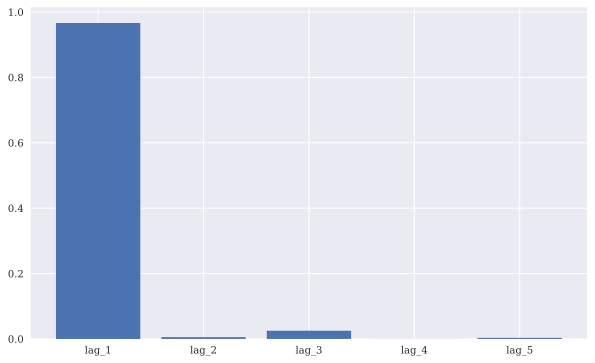

In [45]:
plt.figure(figsize=(10, 6))
plt.bar(cols, reg);
# plt.savefig('../../images/ch15/strat_plot_04.png');

In [46]:
data['Prediction'] = np.dot(data[cols], reg)

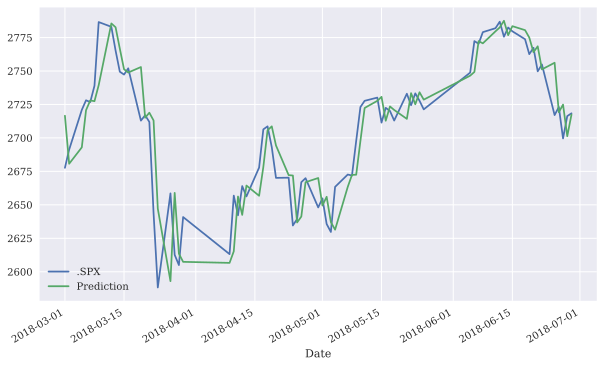

In [47]:
data[[symbol, 'Prediction']].iloc[-75:].plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_plot_05.png');

# Trading Strategies (b)

In [48]:
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt
import warnings

In [51]:
warnings.simplefilter('ignore')
plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = 'serif'
np.random.seed(1000)
%config InlineBackend.figure_format = 'svg'

## Linear OLS Regression

### The Data

In [52]:
raw = pd.read_csv('http://hilpisch.com/tr_eikon_eod_data.csv',
                  index_col=0, parse_dates=True).dropna()

In [53]:
raw.columns

Index(['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', 'SPY', '.SPX', '.VIX',
       'EUR=', 'XAU=', 'GDX', 'GLD'],
      dtype='object')

In [54]:
symbol = 'EUR='

In [55]:
data = pd.DataFrame(raw[symbol])

In [56]:
data['returns'] = np.log(data / data.shift(1))

In [57]:
data.dropna(inplace=True)

In [58]:
data['direction'] = np.sign(data['returns']).astype(int)

In [59]:
data.head()

,EUR=,returns,direction
Date,,,
2010-01-05,1.4368,-0.002988,-1
2010-01-06,1.4412,0.003058,1
2010-01-07,1.4318,-0.006544,-1
2010-01-08,1.4412,0.006544,1
2010-01-11,1.4513,0.006984,1


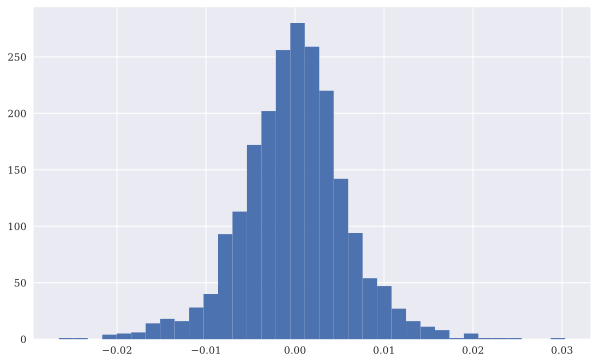

In [60]:
data['returns'].hist(bins=35, figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_01.png')

In [61]:
lags = 2

In [62]:
def create_lags(data):
    global cols
    cols = []
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        data[col] = data['returns'].shift(lag)
        cols.append(col)

In [63]:
create_lags(data)

In [64]:
data.head()

,EUR=,returns,direction,lag_1,lag_2
Date,,,,,
2010-01-05,1.4368,-0.002988,-1,NaN,NaN
2010-01-06,1.4412,0.003058,1,-0.002988,NaN
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544


In [65]:
data.dropna(inplace=True)

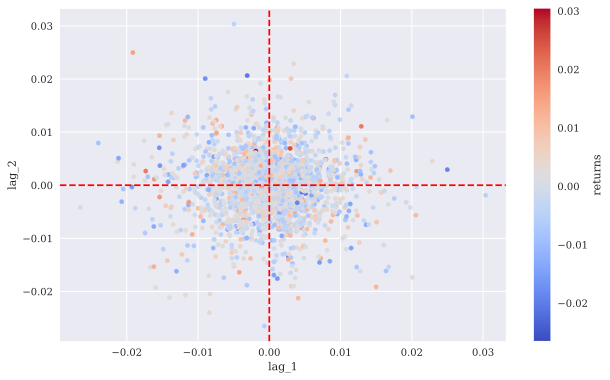

In [66]:
data.plot.scatter(x='lag_1', y='lag_2', c='returns', 
                  cmap='coolwarm', figsize=(10, 6), colorbar=True)
plt.axvline(0, c='r', ls='--')
plt.axhline(0, c='r', ls='--');
# plt.savefig('../../images/ch15/strat_ml_02.png');

### Regression

In [67]:
from sklearn.linear_model import LinearRegression  

In [68]:
model = LinearRegression()  

In [69]:
data['pos_ols_1'] = model.fit(data[cols], data['returns']).predict(data[cols])  

In [70]:
data['pos_ols_2'] = model.fit(data[cols], data['direction']).predict(data[cols])  

In [71]:
data[['pos_ols_1', 'pos_ols_2']].head()

,pos_ols_1,pos_ols_2
Date,,
2010-01-07,-0.000166,-0.000086
2010-01-08,0.000017,0.040404
2010-01-11,-0.000244,-0.011756
2010-01-12,-0.000139,-0.043398
2010-01-13,-0.000022,0.002237


In [72]:
data[['pos_ols_1', 'pos_ols_2']] = np.where(
            data[['pos_ols_1', 'pos_ols_2']] > 0, 1, -1)  

In [73]:
data['pos_ols_1'].value_counts()  

pos_ols_1
-1    1847
 1     288
Name: count, dtype: int64

In [74]:
data['pos_ols_2'].value_counts()  

pos_ols_2
 1    1377
-1     758
Name: count, dtype: int64

In [75]:
(data['pos_ols_1'].diff() != 0).sum()  

np.int64(555)

In [76]:
(data['pos_ols_2'].diff() != 0).sum()  

np.int64(762)

In [77]:
data['strat_ols_1'] = data['pos_ols_1'] * data['returns']

In [78]:
data['strat_ols_2'] = data['pos_ols_2'] * data['returns']

In [79]:
data[['returns', 'strat_ols_1', 'strat_ols_2']].sum().apply(np.exp)

returns        0.810644
strat_ols_1    0.942422
strat_ols_2    1.339286
dtype: float64

In [80]:
(data['direction'] == data['pos_ols_1']).value_counts()  

False    1093
True     1042
Name: count, dtype: int64

In [81]:
(data['direction'] == data['pos_ols_2']).value_counts()  

True     1096
False    1039
Name: count, dtype: int64

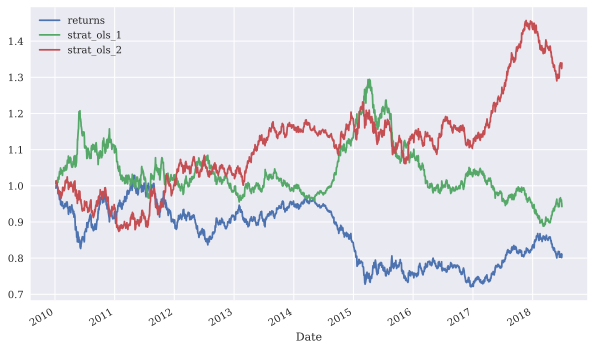

In [82]:
data[['returns', 'strat_ols_1', 'strat_ols_2']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_03.png');

## Clustering

In [83]:
from sklearn.cluster import KMeans

In [84]:
model = KMeans(n_clusters=2, random_state=0)  #  <1>

In [85]:
model.fit(data[cols])

KMeans(n_clusters=2, random_state=0)

In [86]:
data['pos_clus'] = model.predict(data[cols])

In [87]:
data['pos_clus'] = np.where(data['pos_clus'] == 1, -1, 1)  

In [88]:
data['pos_clus'].values

array([ 1,  1,  1, ..., -1,  1,  1])

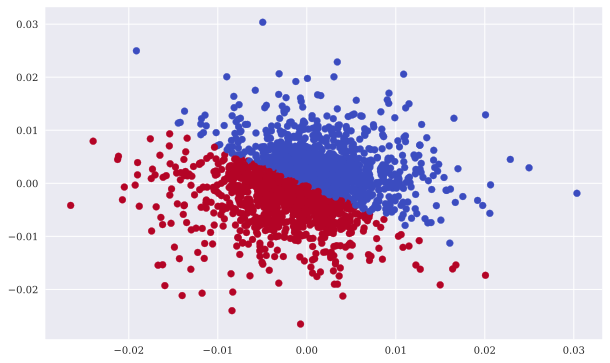

In [89]:
plt.figure(figsize=(10, 6))
plt.scatter(data[cols].iloc[:, 0], data[cols].iloc[:, 1],
            c=data['pos_clus'], cmap='coolwarm');
# plt.savefig('../../images/ch15/strat_ml_04.png');

In [90]:
data['strat_clus'] = data['pos_clus'] * data['returns']

In [91]:
data[['returns', 'strat_clus']].sum().apply(np.exp)

returns       0.810644
strat_clus    1.150545
dtype: float64

In [92]:
(data['direction'] == data['pos_clus']).value_counts()

True     1098
False    1037
Name: count, dtype: int64

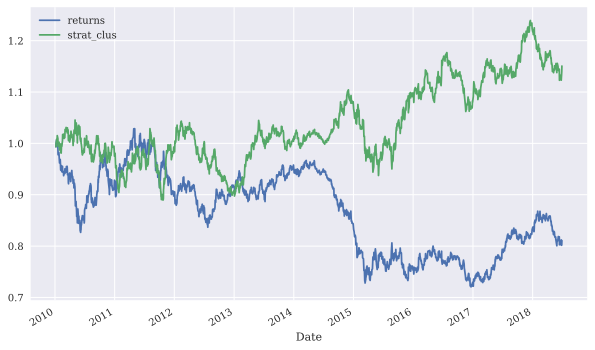

In [93]:
data[['returns', 'strat_clus']].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_05.png');

## Frequency Approach

In [94]:
def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)  
        cols_bin.append(col_bin)

In [95]:
create_bins(data)

In [96]:
data[cols_bin + ['direction']].head()  

,lag_1_bin,lag_2_bin,direction
Date,,,
2010-01-07,1,0,-1
2010-01-08,0,1,1
2010-01-11,1,0,1
2010-01-12,1,1,-1
2010-01-13,0,1,1


In [97]:
grouped = data.groupby(cols_bin + ['direction'])
grouped.size()  

lag_1_bin  lag_2_bin  direction
0          0          -1           239
                       0             4
                       1           258
           1          -1           262
                       1           288
1          0          -1           272
                       0             1
                       1           278
           1          -1           278
                       0             4
                       1           251
dtype: int64

In [98]:
res = grouped['direction'].size().unstack(fill_value=0)  

In [99]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]  

In [100]:
res.style.apply(highlight_max, axis=1)  

In [101]:
data['pos_freq'] = np.where(data[cols_bin].sum(axis=1) == 2, -1, 1)  

In [102]:
(data['direction'] == data['pos_freq']).value_counts()

True     1102
False    1033
Name: count, dtype: int64

In [103]:
data['strat_freq'] = data['pos_freq'] * data['returns']

In [104]:
data[['returns', 'strat_freq']].sum().apply(np.exp)

returns       0.810644
strat_freq    0.989513
dtype: float64

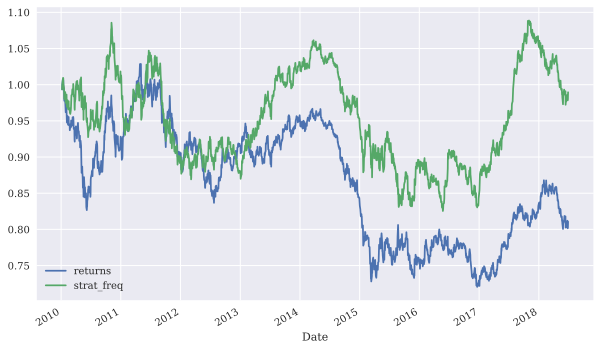

In [105]:
data[['returns', 'strat_freq']].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_06.png');

## Classification Algorithms

In [106]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [107]:
C = 1

In [108]:
models = {
    'log_reg': linear_model.LogisticRegression(C=C),
    'gauss_nb': GaussianNB(),
    'svm': SVC(C=C)
}

In [109]:
def fit_models(data):  
    mfit = {model: models[model].fit(data[cols_bin], data['direction'])
            for model in models.keys()} 

In [110]:
fit_models(data)

In [111]:
def derive_positions(data):  
    for model in models.keys():
        data['pos_' + model] = models[model].predict(data[cols_bin])

In [112]:
derive_positions(data)

In [113]:
def evaluate_strats(data):  
    global sel
    sel = []
    for model in models.keys():
        col = 'strat_' + model 
        data[col] = data['pos_' + model] * data['returns']
        sel.append(col)
    sel.insert(0, 'returns')

In [114]:
evaluate_strats(data)

In [115]:
sel.insert(1, 'strat_freq')

In [116]:
data[sel].sum().apply(np.exp)  

returns           0.810644
strat_freq        0.989513
strat_log_reg     1.243322
strat_gauss_nb    1.243322
strat_svm         0.989513
dtype: float64

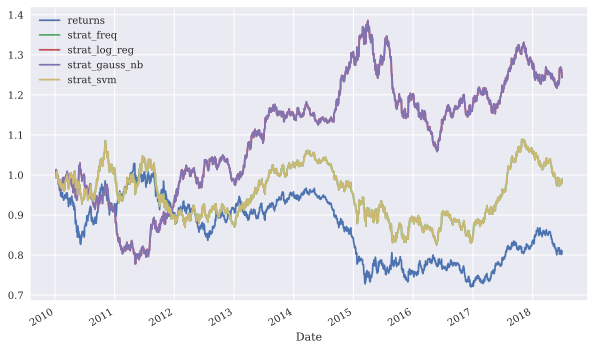

In [117]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_07.png')

In [118]:
data = pd.DataFrame(raw[symbol])

In [119]:
data['returns'] = np.log(data / data.shift(1))

In [120]:
data['direction'] = np.sign(data['returns'])

In [121]:
lags = 5  
create_lags(data)
data.dropna(inplace=True)

In [122]:
create_bins(data)  
cols_bin

['lag_1_bin', 'lag_2_bin', 'lag_3_bin', 'lag_4_bin', 'lag_5_bin']

In [123]:
data[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-12,1,1,0,1,0
2010-01-13,0,1,1,0,1
2010-01-14,1,0,1,1,0
2010-01-15,0,1,0,1,1
2010-01-19,0,0,1,0,1


In [124]:
data.dropna(inplace=True)

In [125]:
fit_models(data)

In [126]:
derive_positions(data)

In [127]:
evaluate_strats(data)

In [128]:
data[sel].sum().apply(np.exp)

returns           0.805002
strat_log_reg     0.971623
strat_gauss_nb    0.986420
strat_svm         2.649423
dtype: float64

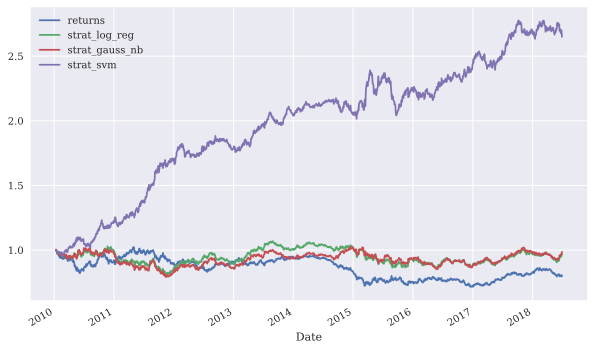

In [129]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_08.png');

In [130]:
mu = data['returns'].mean()  
v = data['returns'].std()  

In [131]:
bins = [mu - v, mu, mu + v]  
bins  

[np.float64(-0.006033537040418664),
 np.float64(-0.00010174015279231288),
 np.float64(0.005830056734834038)]

In [132]:
create_bins(data, bins)

In [133]:
data[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-12,3,3,0,2,1
2010-01-13,1,3,3,0,2
2010-01-14,2,1,3,3,0
2010-01-15,1,2,1,3,3
2010-01-19,0,1,2,1,3


In [134]:
fit_models(data)

In [135]:
derive_positions(data)

In [136]:
evaluate_strats(data)

In [137]:
data[sel].sum().apply(np.exp)

returns           0.805002
strat_log_reg     1.431120
strat_gauss_nb    1.815304
strat_svm         7.165290
dtype: float64

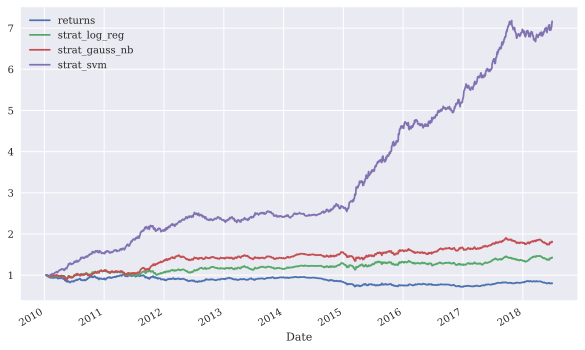

In [138]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_09.png')

### Sequential Train-Test Split

In [139]:
split = int(len(data) * 0.5)

In [140]:
train = data.iloc[:split].copy()  

In [141]:
fit_models(train)  

In [142]:
test = data.iloc[split:].copy()  

In [143]:
derive_positions(test)  

In [144]:
evaluate_strats(test)  

In [145]:
test[sel].sum().apply(np.exp)

returns           0.850291
strat_log_reg     0.952898
strat_gauss_nb    0.941172
strat_svm         1.020519
dtype: float64

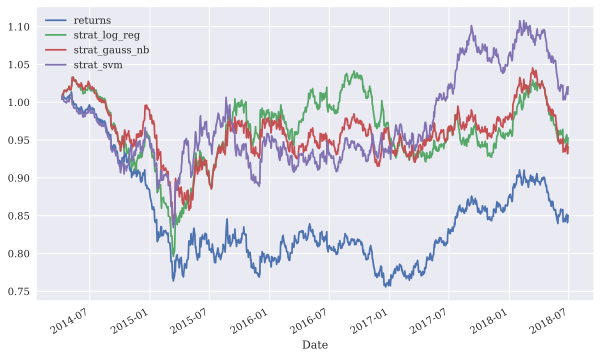

In [146]:
test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_10.png');

### Randomized Train-Test Split

In [147]:
from sklearn.model_selection import train_test_split

In [148]:
train, test = train_test_split(data, test_size=0.5,
                               shuffle=True, random_state=100)

In [149]:
train = train.copy().sort_index()  

In [150]:
train[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-12,3,3,0,2,1
2010-01-13,1,3,3,0,2
2010-01-14,2,1,3,3,0
2010-01-15,1,2,1,3,3
2010-01-20,1,0,1,2,1


In [151]:
test = test.copy().sort_index()  

In [152]:
fit_models(train)

In [153]:
derive_positions(test)

In [154]:
evaluate_strats(test)

In [155]:
test[sel].sum().apply(np.exp)

returns           0.878078
strat_log_reg     0.801787
strat_gauss_nb    0.765009
strat_svm         0.730141
dtype: float64

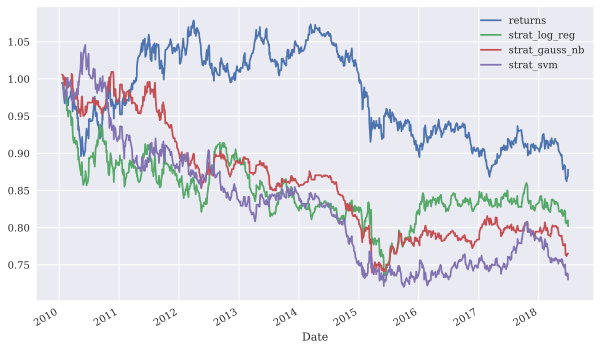

In [156]:
test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_11.png');

## Deep Neural Network

### DNN with scikit-learn

In [157]:
from sklearn.neural_network import MLPClassifier

In [158]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=2 * [250], random_state=1)

In [159]:
%time model.fit(data[cols_bin], data['direction'])

CPU times: total: 4.41 s
Wall time: 5.4 s


MLPClassifier(alpha=1e-05, hidden_layer_sizes=[250, 250], random_state=1,
              solver='lbfgs')

In [160]:
data['pos_dnn_sk'] = model.predict(data[cols_bin])

In [161]:
data['strat_dnn_sk'] = data['pos_dnn_sk'] * data['returns']

In [162]:
data[['returns', 'strat_dnn_sk']].sum().apply(np.exp)

returns          0.805002
strat_dnn_sk    39.221155
dtype: float64

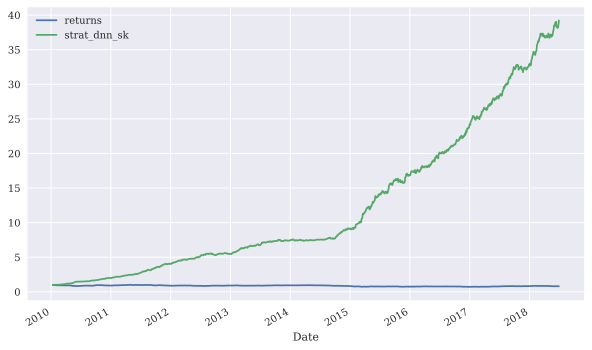

In [163]:
data[['returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_12.png');

In [164]:
train, test = train_test_split(data, test_size=0.5, random_state=100)

In [165]:
train = train.copy().sort_index()

In [166]:
test = test.copy().sort_index()

In [167]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=500,
                     hidden_layer_sizes=3 * [500], random_state=1)  

In [168]:
%time model.fit(train[cols_bin], train['direction'])

CPU times: total: 39.9 s
Wall time: 41.2 s


MLPClassifier(alpha=1e-05, hidden_layer_sizes=[500, 500, 500], max_iter=500,
              random_state=1, solver='lbfgs')

In [169]:
test['pos_dnn_sk'] = model.predict(test[cols_bin])

In [170]:
test['strat_dnn_sk'] = test['pos_dnn_sk'] * test['returns']

In [171]:
test[['returns', 'strat_dnn_sk']].sum().apply(np.exp)

returns         0.878078
strat_dnn_sk    1.305812
dtype: float64

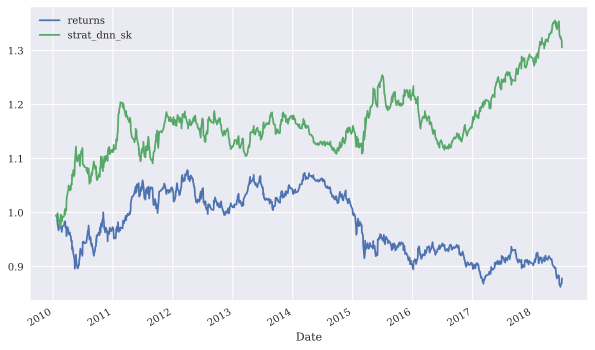

In [172]:
test[['returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_13.png');

### DNN with Keras & TensorFlow Backend

In [174]:
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential

In [175]:
def create_model():
    np.random.seed(100)
    tf.random.set_seed(100)
    model = Sequential()
    model.add(Dense(16, activation='relu', input_dim=lags))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop',
                  metrics=['accuracy'])
    return model

In [176]:
data_ = (data - data.mean()) / data.std()
data['direction_'] = np.where(data['direction'] == 1, 1, 0)

In [177]:
model = create_model()

In [178]:
%%time
model.fit(data_[cols], data['direction_'],
          epochs=50, verbose=False)

CPU times: total: 125 ms
Wall time: 3.05 s


In [179]:
model.evaluate(data_[cols], data['direction_'])

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - accuracy: 0.5875 - loss: 0.6663


[0.6682919859886169, 0.5867729783058167]

In [180]:
pred = np.where(model.predict(data_[cols]) > 0.5, 1, 0) 
pred[:10].flatten()

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step


array([1, 1, 0, 1, 0, 1, 1, 1, 1, 0])

In [181]:
data['pos_dnn_ke'] = np.where(pred > 0, 1, -1)  

In [182]:
data['strat_dnn_ke'] = data['pos_dnn_ke'] * data['returns']

In [183]:
data[['returns', 'strat_dnn_ke']].sum().apply(np.exp)

returns         0.805002
strat_dnn_ke    6.983856
dtype: float64

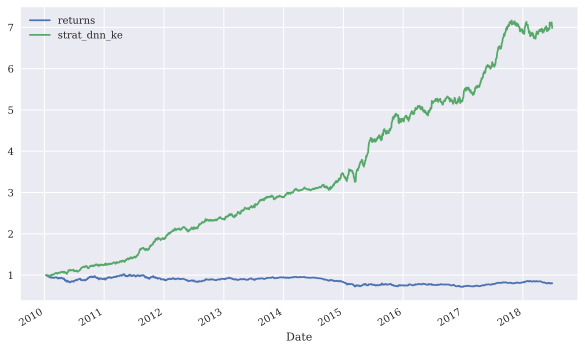

In [184]:
data[['returns', 'strat_dnn_ke']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_14.png');

In [185]:
mu, std = train.mean(), train.std()

In [186]:
train_ = (train - mu) / mu.std()

In [187]:
model = create_model()

In [188]:
train['direction_'] = np.where(train['direction'] > 0, 1, 0)

In [189]:
%%time
model.fit(train_[cols], train['direction_'],
          epochs=50, verbose=False)

CPU times: total: 297 ms
Wall time: 2.27 s


In [190]:
test_ = (test - mu) / std

In [191]:
test['direction_'] = np.where(test['direction'] > 0, 1, 0)

In [192]:
model.evaluate(test_[cols], test['direction_'])

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.4801 - loss: 1.2456


[1.1623287200927734, 0.501876175403595]

In [193]:
pred = np.where(model.predict(test_[cols]) > 0.5, 1, 0) 
pred[:10].flatten()

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


array([0, 1, 1, 0, 0, 1, 1, 0, 0, 1])

In [194]:
test['pos_dnn_ke'] = np.where(pred > 0, 1, -1)

In [195]:
test['strat_dnn_ke'] = test['pos_dnn_ke'] * test['returns']

In [196]:
test[['returns', 'strat_dnn_sk', 'strat_dnn_ke']].sum().apply(np.exp)

returns         0.878078
strat_dnn_sk    1.305812
strat_dnn_ke    1.045385
dtype: float64

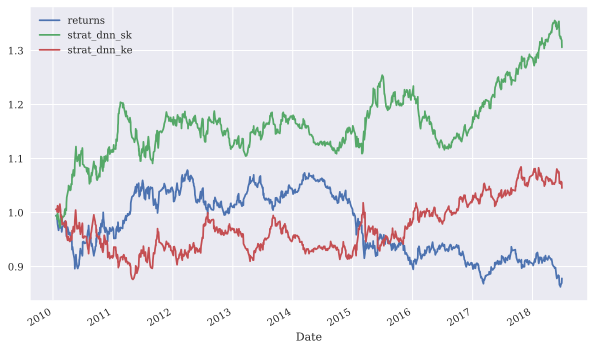

In [197]:
test[['returns', 'strat_dnn_sk', 'strat_dnn_ke']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_15.png');